# Tutorial notebook 5: Cell Type Generation

In this tutorial, we will demonstrate how to use a pretrained Cell2Sentence (C2S) model to generate new cells conditioned on a specific cell type. Cell generation is a powerful tool for simulating new data, studying cell diversity, and exploring the characteristics of different cell types. By leveraging the generative capabilities of C2S models, we can create realistic cell data that follows the patterns learned from existing datasets.

In this tutorial, you will:
1. Load an immune tissue single-cell dataset from Domínguez Conde et al. (preprocessed in tutorial notebook 0, two sample donors)
    - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
2. Load a pretrained C2S model that is capable of generating cells based on cell type.
3. Generate new cells conditioned on a specified cell type using the C2S model.

Let's get started!

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [1]:
# Python built-in libraries
import os
import pickle
import random
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import generate_cells_conditioned_on_cell_type
from cell2sentence.utils import (
    post_process_generated_cell_sentences,
    reconstruct_expression_from_cell_sentence
)

/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [3]:
DATA_PATH = "/home/sr2464/palmer_scratch/C2S_Files_Syed/Cell2Sentence_Datasets/dominguez_conde_immune_tissue_two_donors_preprocessed_tutorial_0.h5ad"

In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs = adata.obs[["cell_type", "tissue", "batch_condition", "organism", "sex"]]

In [6]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,female


In [7]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


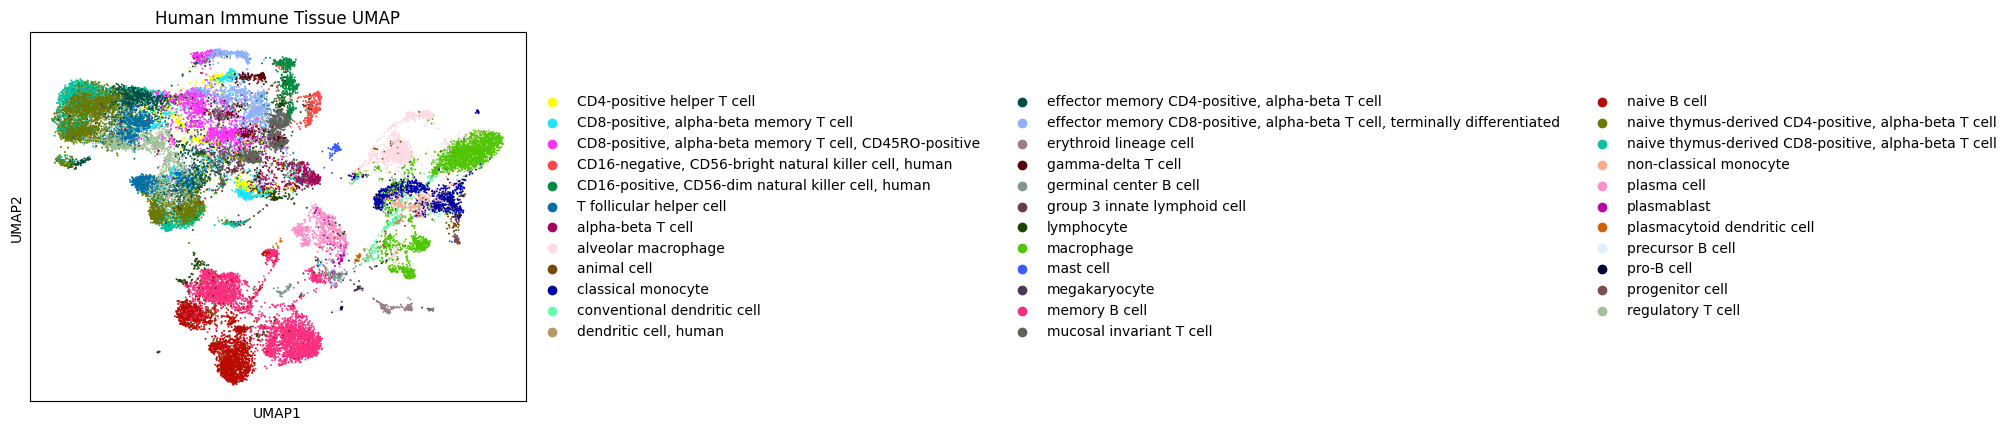

In [8]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [9]:
adata.X.max()

3.408124

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [10]:
adata_obs_cols_to_keep = ["cell_type", "tissue", "batch_condition", "organism", "sex"]

In [11]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 29773/29773 [00:11<00:00, 2525.14it/s]


In [12]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

In [13]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'Pan_T7935490_AAACCTGCAAATTGCC',
 'cell_sentence': 'RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5

This time, we will leave off creating our CSData object until after we load our C2S model. This is because along with the model checkpoint, we saved the indices of train, val, and test set cells, which will allow us to select out test set cells for inference.

# Load C2S Model

Now, we will load a C2S model which we will perform cell type-conditioned single cell generation with. We highly recommend loading either a model which you have finetuned to do cell type generation with (see tutorial notebook 3 for how to perform finetuning) or the C2S-Pythia-410M conditional cell type generation foundation model which was pretrained to do cell type-conditioned generation on a diverse array of datasets (details in the repo ReadME, Model Zoo section).

For this tutorial, we will load the best checkpoint of a model which we finetuned to do cell type-conditioned cell generation with using tutorial notebook 3. This model was intitialized from the C2S-Pythia-410M conditional cell type generation foundation model, and finetuned for cell generation on the training set of our immune tissue dataset. We load it here as follows:

In [14]:
# Define CSModel object
cell_type_prediction_model_path = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_3/2024-08-30-10_59_21_finetune_cell_type_generation/checkpoint-3700"
save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_5"
save_name = "cell_type_generation_pythia_410M_inference"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


We will also load the data split indices saved alongside the C2S model checkpoint, so that we know which cells were part of the training and validation set. We will do inference on unseen test set cells, which are 10% of the original data.

In [15]:
base_path = "/".join(cell_type_prediction_model_path.split("/")[:-1])
print(cell_type_prediction_model_path)
print(base_path)

/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_3/2024-08-30-10_59_21_finetune_cell_type_generation/checkpoint-3700
/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_3/2024-08-30-10_59_21_finetune_cell_type_generation


In [16]:
with open(os.path.join(base_path, 'data_split_indices_dict.pkl'), 'rb') as f:
    data_split_indices_dict = pickle.load(f)
data_split_indices_dict.keys()

dict_keys(['train', 'val', 'test'])

In [17]:
print(len(data_split_indices_dict["train"]))
print(len(data_split_indices_dict["val"]))
print(len(data_split_indices_dict["test"]))

23847
2948
2978


Select out test set cells from full arrow dataset

In [18]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

In [19]:
test_ds = arrow_ds.select(data_split_indices_dict["test"])
test_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 2978
})

Here, we do not need to create a CSData object. We can simply supply cell types from our test dataset to the cell generation function from tasks.py

# Generate cells conditioned on cell type

Now that we have loaded our finetuned cell generation model and have our test set cells, we will generate cells using the generate_cells_conditioned_on_cell_type() function from tasks.py, which takes as input a C2S model object as well as a list of cell type to prompt C2S to generate. The function will return 1 generated cell sentences for each cell type supplied, and will handle prompt formatting for us.

In [20]:
cell_types_to_generate = test_ds["cell_type"]

In [21]:
print(len(cell_types_to_generate))
cell_types_to_generate[:3]

2978


['CD8-positive, alpha-beta memory T cell',
 'CD8-positive, alpha-beta memory T cell',
 'CD8-positive, alpha-beta memory T cell']

In [22]:
inference_batch_size = 16

In [23]:
generated_cells = generate_cells_conditioned_on_cell_type(
    csmodel=csmodel, 
    cell_types_list=cell_types_to_generate, 
    n_genes=200, 
    organism="Homo sapiens",
    inference_batch_size=inference_batch_size,
    max_num_tokens=1024,
    use_flash_attn=False,  # at smaller sequence lengths (< 1024), flash attention doesn't significantly benefit text generation.
    do_sample=True,
    top_k=50,
    top_p=0.95,
)

Reloading model from path on disk: /home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_5/cell_type_generation_pythia_410M_inference
Generating 2978 cells using CSModel...


100%|██████████| 2978/2978 [1:54:29<00:00,  2.31s/it]


We can see that the function has generated 2978 cells given the cell types which we provided it, mimicing the cell type frequency in the real test set. We can save our generated cells below:

In [24]:
len(generated_cells)

2978

In [25]:
with open('/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/generated_cells.pkl', 'wb') as f:
    pickle.dump(generated_cells, f)

Here, we view a few of our generated cell sentences:

In [26]:
generated_cells[:5]

['MALAT1 TMSB4X B2M MT-CO1 RPLP1 ACTB MT-CO2 RPS27 HSPA1A MT-ND3 RPL41 HSPA1B MT-CYB RPS12 MT-ATP8 RPL28 RPS19 EEF1A1 RPL13 MT-CO3 DNAJB1 RPL30 RPL10 RPS15A MT-ND4L TPT1 RPL39 JUN RPL37 RPL32 RPS28 HLA-B RPS3 RPS3A RPL19 RPS27A BTG1 HLA-C RPL36 RPL34 MT-ND4 RPL26 RPS4X RPS23 RPL11 RPS18 RPL35A RPS6 RPL18 RPS21 RPS29 FOS HSPA8 RPS14 RPL37A RPL7A RPL29 RPLP2 RPL12 RPS8 RPS15 MT-ATP6 RPS25 TMSB10 RPS2 RPL8 RPL18A RPL3 CCL5 RPL15 RPS24 TRBV19 PFN1 RPLP0 MTRNR2L12 RPL21 RPS13 RPL6 RPL23A MT-ND1 PTMA HSP90AB1 FTL RPL9 VIM ATP5F1E UBB CD3E RPL36A RPS9 CFL1 RPL35 HSP90AA1 RPL24 ACTG1 PPP1R15A SH3BGRL3 IFITM1 MT-ND2 RPL5 RPL13A EIF1 EEF1B2 HLA-A FAU H3-3B UBA52 HLA-E ARHGDIB IL32 RPL27 RPL17 MYL12A RPL14 LSP1 PPIA EEF1D RPS5 RPSA CALM1 JUNB PTPRC DUSP1 HNRNPA1 PABPC1 SLC2A3 NACA SARAF RAC2 TNFAIP3 RACK1 TRAV9-2 MYADM CORO1A TMA7 FTH1 EEF2 CD2 RPL10A LTB S100A4 RPS16 CD52 KLF6 SRSF7 BTF3 FYB1 GZMA CD3D SERF2 TSC22D3 RPL38 IL7R DNAJA1 MT-ND5 CYTIP NPM1 H3-3A TOMM7 GAPDH TRBC1 COTL1 ARPC2 STK17B H

# Post processing and reconstruction

Now that we have generated cell sentences conditioned on cell type, we need to perform some postprocessing steps, namely:
1. Removing words that are not gene names in the dataset
2. Deal with genes which were generated more than once in a cell sentence (duplicate genes)

We will use C2S functions to do this post processing, as well as convert our generated cell sentences back into expression vectors for visualization.

First, we get a vocabulary list of gene names from our AnnData object. This will helps us determine what is a real gene word for our data, and what was some nonsense word or unknown gene mistakenly generated by the model.

In [27]:
vocab_list = list(vocabulary.keys())
print(len(vocab_list))
vocab_list[:4]

23944


['RP11-34P13', 'RP11-34P13-3', 'AP006222', 'LINC01409']

In [32]:
adata_test.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


We post-process all generated cell sentences, which will remove non-gene words in the sentence and average the position of genes which appear multiple times in the generated cell sentence.

In [33]:
post_processed_sentences_list = []
num_genes_replaced_list = []
for idx in tqdm(range(len(generated_cells))):
    post_processed_sentence, num_genes_replaced = post_process_generated_cell_sentences(
        cell_sentence=generated_cells[idx],
        vocab_list=vocab_list,
        replace_nonsense_string="NOT_A_GENE",
    )
    # post_processed_sentence is a list of genes, with non-genes replaced with replace_nonsense_string
    post_processed_sentence = " ".join(post_processed_sentence)  # rejoin into one cell sentence string
    post_processed_sentence = post_processed_sentence.replace(" NOT_A_GENE", "")  # replace nonsense string
    post_processed_sentences_list.append(post_processed_sentence)
    num_genes_replaced_list.append(num_genes_replaced)

100%|██████████| 2978/2978 [01:31<00:00, 32.64it/s]


In [34]:
avg_num_genes_replaced = sum(num_genes_replaced_list) / len(num_genes_replaced_list)
print(f"avg_num_genes_replaced: {avg_num_genes_replaced:.5f}")

avg_num_genes_replaced: 1.13969


We can see that our model was very accurate, only generating 1.14 invalid genes per cell sentence on average. We can see an example of a cell sentence before and after post processing:

In [35]:
print("Predicted sentence 1:")
print(generated_cells[0])
print("Post-processed sentence 1")
print(post_processed_sentences_list[0])

Predicted sentence 1:
MALAT1 TMSB4X B2M MT-CO1 RPLP1 ACTB MT-CO2 RPS27 HSPA1A MT-ND3 RPL41 HSPA1B MT-CYB RPS12 MT-ATP8 RPL28 RPS19 EEF1A1 RPL13 MT-CO3 DNAJB1 RPL30 RPL10 RPS15A MT-ND4L TPT1 RPL39 JUN RPL37 RPL32 RPS28 HLA-B RPS3 RPS3A RPL19 RPS27A BTG1 HLA-C RPL36 RPL34 MT-ND4 RPL26 RPS4X RPS23 RPL11 RPS18 RPL35A RPS6 RPL18 RPS21 RPS29 FOS HSPA8 RPS14 RPL37A RPL7A RPL29 RPLP2 RPL12 RPS8 RPS15 MT-ATP6 RPS25 TMSB10 RPS2 RPL8 RPL18A RPL3 CCL5 RPL15 RPS24 TRBV19 PFN1 RPLP0 MTRNR2L12 RPL21 RPS13 RPL6 RPL23A MT-ND1 PTMA HSP90AB1 FTL RPL9 VIM ATP5F1E UBB CD3E RPL36A RPS9 CFL1 RPL35 HSP90AA1 RPL24 ACTG1 PPP1R15A SH3BGRL3 IFITM1 MT-ND2 RPL5 RPL13A EIF1 EEF1B2 HLA-A FAU H3-3B UBA52 HLA-E ARHGDIB IL32 RPL27 RPL17 MYL12A RPL14 LSP1 PPIA EEF1D RPS5 RPSA CALM1 JUNB PTPRC DUSP1 HNRNPA1 PABPC1 SLC2A3 NACA SARAF RAC2 TNFAIP3 RACK1 TRAV9-2 MYADM CORO1A TMA7 FTH1 EEF2 CD2 RPL10A LTB S100A4 RPS16 CD52 KLF6 SRSF7 BTF3 FYB1 GZMA CD3D SERF2 TSC22D3 RPL38 IL7R DNAJA1 MT-ND5 CYTIP NPM1 H3-3A TOMM7 GAPDH TRBC1 

Now, we reconstruct expression vectors from the cell sentence. From tutorial notebook 1, we know the slope and intercept values for the linear reconstruction model for this dataset.

In [36]:
slope = -0.6756886579917628
intercept = 2.237853249084892

We will utilize the reconstruct_expression_from_cell_sentence() function from `utils.py` to reconstruct an expression vector from our generated cell sentence. The expression vector will have column features that match the order of vocab_list, so <font color="red"> make sure that vocab_list reflects the exact gene ordering in the original data!</font>

In [37]:
all_reconstructed_expression_vectors = []
for idx in tqdm(range(len(post_processed_sentences_list))):
    expression_vector = reconstruct_expression_from_cell_sentence(
        cell_sentence_str=post_processed_sentences_list[idx],
        delimiter=" ",
        vocab_list=vocab_list,
        slope=slope,
        intercept=intercept,
    )
    all_reconstructed_expression_vectors.append(expression_vector)

all_reconstructed_expression_vectors = np.stack(all_reconstructed_expression_vectors)

100%|██████████| 2978/2978 [00:06<00:00, 458.33it/s]


In [38]:
all_reconstructed_expression_vectors.shape

(2978, 23944)

In [39]:
all_reconstructed_expression_vectors.dtype

dtype('float32')

In [40]:
np.save("/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/cell_generation_all_reconstructed_expression_vectors.npy", all_reconstructed_expression_vectors)

# Visualization of Generated cells

Now that post processing and the conversion back to expression vectors using the linear model is complete, let's visualize the cells we have generated by putting them together into one AnnData object and visualizing original data and generated data side by side.

First, we retrieve the original data from our adata object, subsetting to the same test set cells:

In [29]:
adata_test = adata[data_split_indices_dict["test"], :].copy()
adata_test

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
del adata_test.uns
del adata_test.obsm
del adata_test.varm
del adata_test.obsp

In [31]:
adata_test

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Now, we restrict the original adata to the top 200 genes, to match cells which we have generated with 200 genes.

In [41]:
adata_test.X = adata_test.X.toarray().astype(np.float32)

In [42]:
top_k_gene_count = 200

In [43]:
for cell_idx in tqdm(range(adata_test.X.shape[0])):
    ind = np.argpartition(adata_test.X[cell_idx], -top_k_gene_count)[-top_k_gene_count:]
    ind.sort()
    all_but_ind = np.setdiff1d(np.array(list(range(adata_test.X.shape[1])), dtype=np.int64), ind)
    adata_test.X[cell_idx, all_but_ind] = 0

100%|██████████| 2978/2978 [00:04<00:00, 605.98it/s]


In [44]:
print(adata_test.X.shape)

(2978, 23944)


In [45]:
print(np.nonzero(adata_test.X[0])[0].shape)
print(np.nonzero(adata_test.X[1])[0].shape)
print(np.nonzero(adata_test.X[2])[0].shape)

(200,)
(200,)
(200,)


Now, we create another AnnData object with our C2S-generated cells

In [46]:
generated_obs_df = pd.DataFrame({
    "cell_type": cell_types_to_generate
}, index=[f"C2S_gen_cell_{idx}" for idx in range(len(cell_types_to_generate))])
print(generated_obs_df.shape)
generated_obs_df.head()

(2978, 1)


,cell_type
C2S_gen_cell_0,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_1,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_2,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_3,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_4,"CD8-positive, alpha-beta memory T cell"


In [47]:
generated_adata = anndata.AnnData(
    X=all_reconstructed_expression_vectors,
    obs=generated_obs_df,
    var=adata_test.var.copy(),
)
generated_adata

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [48]:
generated_adata.obs.head()

,cell_type
C2S_gen_cell_0,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_1,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_2,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_3,"CD8-positive, alpha-beta memory T cell"
C2S_gen_cell_4,"CD8-positive, alpha-beta memory T cell"


In [49]:
print(np.nonzero(generated_adata.X[0])[0].shape)
print(np.nonzero(generated_adata.X[1])[0].shape)
print(np.nonzero(generated_adata.X[2])[0].shape)

(199,)
(199,)
(198,)


Our generated cells will have a few less genes than 200, since 1-2 genes were removed during post processing.

We can quickly visualize separate UMAPs of the generated data, to see what clusters there are in the generated cells:

In [50]:
del generated_adata.uns
del generated_adata.obsm
del generated_adata.varm
del generated_adata.obsp

In [51]:
generated_adata

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [52]:
sc.tl.pca(generated_adata)

In [53]:
sc.pp.neighbors(generated_adata)  # , metric="cosine"

In [54]:
sc.tl.umap(generated_adata)

In [55]:
generated_adata

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


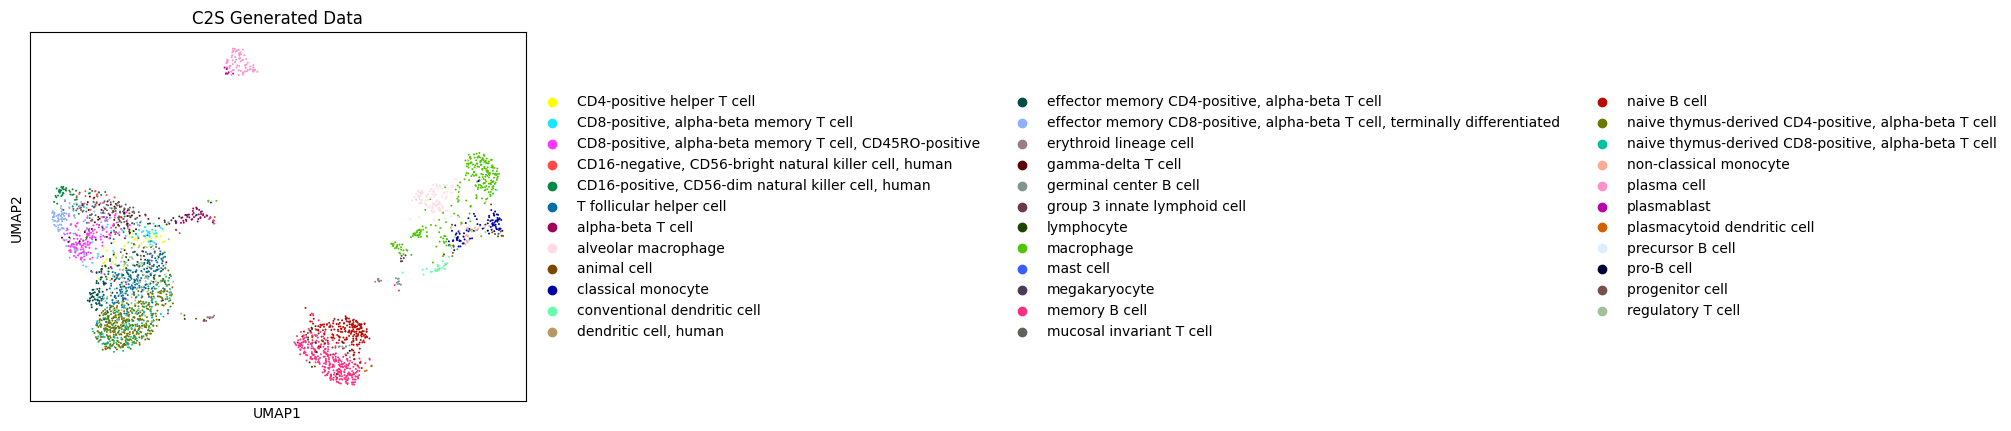

In [56]:
sc.pl.umap(
    generated_adata,
    color="cell_type",
    size=8,
    title="C2S Generated Data"
)

Our generated data looks to have good cell type clustering and structure! Let's quickly make a separate UMAP of the original data to compare:

In [57]:
adata_test

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [58]:
sc.tl.pca(adata_test)

In [59]:
sc.pp.neighbors(adata_test)

In [60]:
sc.tl.umap(adata_test)

In [61]:
adata_test

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


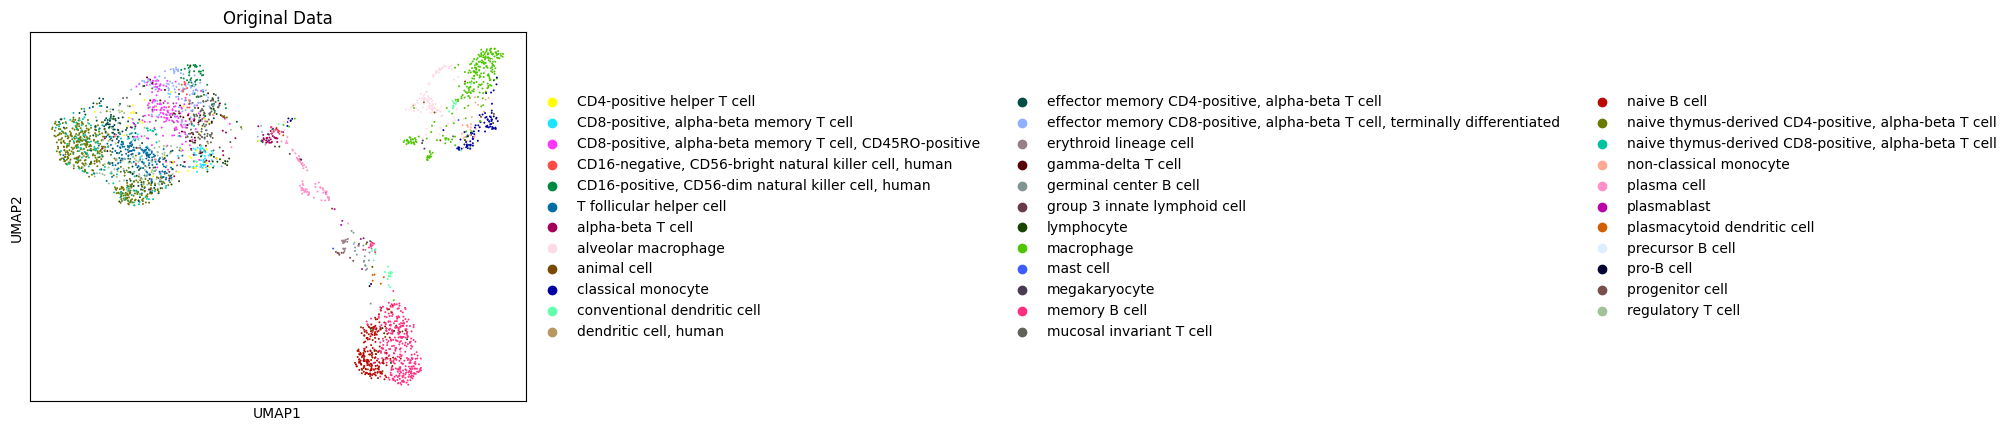

In [62]:
sc.pl.umap(
    adata_test,
    color="cell_type",
    size=8,
    title="Original Data"
)

The original data has a similar structure. As a last check before we make a joint UMAP, we can look at a heatmap of gene expression between generated and original data:

In [63]:
markers = ['MALAT1', 'MT-CO2', 'MT-CO1', 'MT-ND3', 'MT-ND4L', 'MT-CO3', 'MT-CYB', 'MT-ATP8', 'MT-ND4', 'MT-ATP6', 'MT-ND5', 'MT-ND2', 'MT-ND1', 'MTRNR2L12', 'HSP90AA1', 'HSPA1A', 'HSPA1B', 'DNAJB1', 'FOSB', 'HSP90AB1', 'HSPA8', 'JUNB', 'FOS', 'DUSP1', 'BTG1', 'JUN', 'FTL', 'B2M', 'RPL41', 'RPLP1', 'RPS27', 'RPL10', 'RPL13', 'RPS12', 'RPL28', 'RPS19', 'RPL39', 'RPS15A', 'RPS3A', 'RPS27A', 'RPL32', 'RPS28', 'RPL34', 'RPS14', 'RPL30', 'RPS18', 'RPL37', 'RPL11', 'RPS21', 'RPS23', 'RPL19', 'RPS3', 'RPL18A', 'RPS15', 'RPL26', 'RPL3', 'RPS6', 'RPS8', 'RPL35A', 'RPLP2', 'RPL12', 'RPS2', 'RPL21', 'RPL36', 'RPL14', 'RPS13', 'RPL18', 'RPL7A', 'RPS25', 'RPL8', 'RPS4X', 'RPL29', 'RPL23A', 'RPL9', 'RPS24', 'RPLP0', 'RPS29', 'RPL17', 'RPL37A', 'RPL15', 'RPS7', 'RPL6', 'RPL10A', 'RPS16', 'RPL5', 'EEF1A1', 'RPL13A', 'RPL22', 'RPS5', 'TPT1', 'RPL35', 'RPL36A', 'RPS9', 'RPL24', 'PTMA', 'RPL38', 'FAU', 'HLA-B', 'RPSA', 'EEF1B2', 'HLA-A', 'UBA52', 'TMSB4X', 'RPL4', 'EEF1G', 'EIF1', 'ACTB', 'NACA', 'HLA-C', 'RACK1', 'PABPC1', 'RPL27', 'PPP1R15A', 'TMSB10', 'HSPH1', 'PNRC1', 'RPL31', 'H3-3B', 'RPS11', 'EEF2', 'BTG2', 'PFDN5', 'RPL7', 'HNRNPA2B1', 'SARAF', 'BTF3', 'NPM1', 'FTH1', 'HNRNPA1', 'RPS20', 'CD3E', 'RPL36AL', 'MT-ND6', 'HSPE1', 'NCL', 'SRSF7', 'CD8A', 'HNRNPDL', 'ZFP36L2', 'TUBA1A', 'SLC2A3', 'CD3D', 'EIF4A2', 'HNRNPU', 'SRSF5', 'RPL27A', 'RPS17', 'RPL23', 'EIF4A1', 'CD7', 'PTPRC', 'HSPD1', 'DDX5', 'H3-3A', 'EIF4B', 'SERF2', 'SLC25A5', 'EIF3E', 'RPS4Y1', 'CD52', 'TOMM7', 'PCBP2', 'IL7R', 'SLC25A6', 'RBM39', 'EIF3F', 'RPS26', 'MYL12A', 'EIF3K', 'CD69', 'RPL22L1', 'TUBA1B', 'EIF3G', 'ATP5F1E', 'EIF3H', 'CFL1', 'EIF4A3', 'UBC', 'RAC2', 'CD8B', 'CD3G', 'RGS2', 'SRSF3', 'EIF5A', 'SFPQ', 'TUBA4A', 'EIF3D', 'EIF4G2', 'EIF3L', 'HNRNPC', 'TSC22D3', 'EIF1AX', 'HINT1', 'RPS10', 'SLC25A3', 'RPS27L']

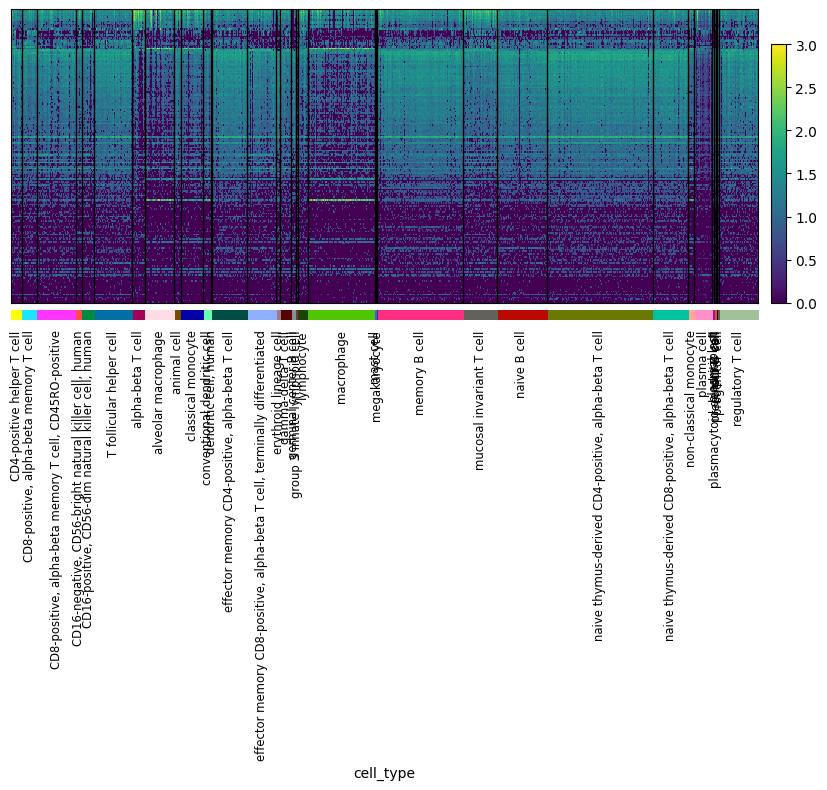

In [64]:
sc.pl.heatmap(adata_test, markers, groupby='cell_type', swap_axes=True, vmax=3.0)

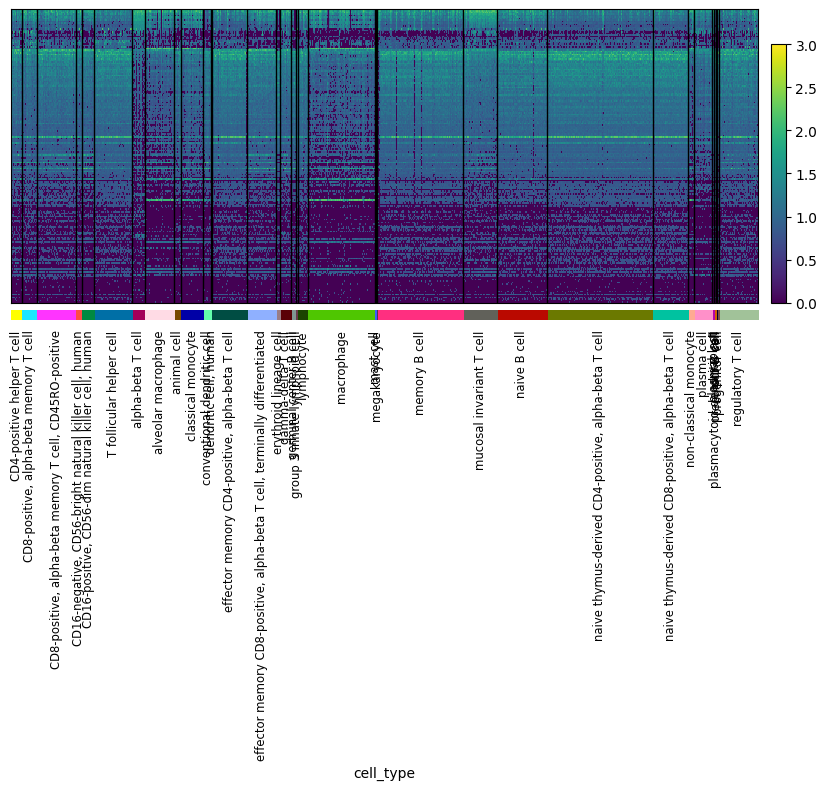

In [65]:
sc.pl.heatmap(generated_adata, markers, groupby='cell_type', swap_axes=True, vmax=3.0)

We can see from the heatmaps that the generated cells have very realistic gene expression profiles compared to the original data, which is promising. It indicates that the cell generation of our C2S model is accurate, and the linear model is able to reconstruct gene expression effectively.

Now, we will move on to visualizing a joint UMAP of generated and original ground truth cells, so that all cells are in the same joint space.

# Combined UMAP in shared space
Now, we create a combined AnnData object and run PCA, neighbors, and UMAP:

In [68]:
del adata_test.uns
del adata_test.obsm
del adata_test.varm
del adata_test.obsp

del generated_adata.uns
del generated_adata.obsm
del generated_adata.varm
del generated_adata.obsp

In [69]:
adata_test

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex', 'data_label'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [70]:
generated_adata

AnnData object with n_obs × n_vars = 2978 × 23944
    obs: 'cell_type', 'data_label'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [66]:
adata_test.obs["data_label"] = "Original Data"
generated_adata.obs["data_label"] = "C2S Generated Data"

In [67]:
print(adata_test.X.shape)
print(adata_test.X.max())
print(adata_test.X[0].sum())
print(adata_test.X[0].max())
print(adata_test.X[0].mean())

(2978, 23944)
3.3575494
209.48633
1.9250746
0.008749011


In [71]:
print(generated_adata.X.shape)
print(generated_adata.X.max())
print(generated_adata.X[0].sum())
print(generated_adata.X[0].max())
print(generated_adata.X[0].mean())

(2978, 23944)
2.2378533
193.574
2.2378533
0.008084447


In [72]:
concat_adata = anndata.concat([adata_test, generated_adata], axis=0)
concat_adata

AnnData object with n_obs × n_vars = 5956 × 23944
    obs: 'cell_type', 'data_label'

In [73]:
concat_adata.var = adata_test.var.copy()
concat_adata

AnnData object with n_obs × n_vars = 5956 × 23944
    obs: 'cell_type', 'data_label'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [74]:
Counter(concat_adata.obs["data_label"])

Counter({'Original Data': 2978, 'C2S Generated Data': 2978})

In [75]:
sc.tl.pca(concat_adata)

In [76]:
sc.pp.neighbors(concat_adata)

In [77]:
sc.tl.umap(concat_adata)

In [78]:
concat_adata

AnnData object with n_obs × n_vars = 5956 × 23944
    obs: 'cell_type', 'data_label'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/tmp/tmp.cdyXGrsOEn/ipykernel_784881/2650716503.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


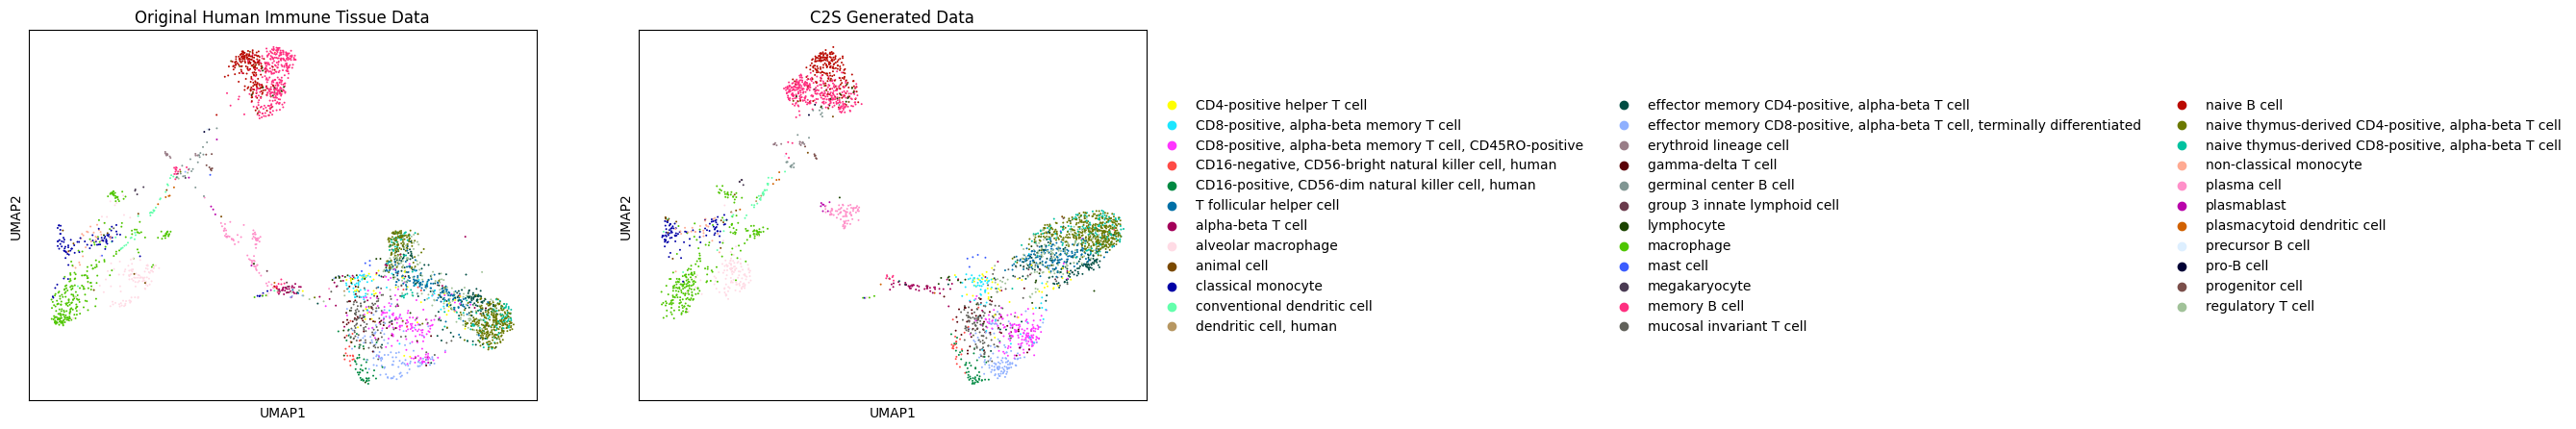

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax = sc.pl.umap(
    concat_adata[concat_adata.obs["data_label"] == "Original Data", :],
    color="cell_type",
    size=8,
    title="Original Human Immune Tissue Data",
    show=False,
    legend_loc=None,
    ax=ax1,
)
sc.pl.umap(
    concat_adata[concat_adata.obs["data_label"] == "C2S Generated Data", :],
    color="cell_type",
    size=8,
    title="C2S Generated Data",
    show=False,
    ax=ax2,
)
plt.tight_layout()
plt.show()
plt.close()

We can see that the generated data by our C2S model (right) comes very close to the original data (left), which is promising for the potential of C2S to generate realistic data. These cells are being visualized after conversion back to expression vectors from generated cell sentences, so we can also observe that we did not lose too much information in our data by going to cell sentences and back to expression vectors. This allows us to leverage the strengths and generation ability of LLMs without losing too much information.